**Importing important Libraries**




In [9]:

import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix
from PIL import Image
import shutil


In [10]:
import time
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from sklearn.metrics import classification_report
import numpy as np
import cv2
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import torchvision
from torchvision import transforms
from torchinfo import summary
import torchvision.models as models
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from tqdm.notebook import tqdm
from sklearn.metrics import accuracy_score
import PIL
import matplotlib.pyplot as plt
import seaborn as sns
import time
from collections import OrderedDict
import platform
import psutil
import random
import glob
from tqdm import tqdm
from PIL import Image
from torchvision import transforms
from torchvision.transforms import ColorJitter, RandomRotation, RandomResizedCrop
from torchvision.transforms.functional import gaussian_blur
from PIL import ImageOps
from tabulate import tabulate

In [11]:
cpu_info = platform.processor()

ram_info = psutil.virtual_memory()
total_ram_gb = ram_info.total / (1024 ** 3)

try:
    gpu_info = !nvidia-smi --query-gpu=gpu_name --format=csv
    gpu_name = gpu_info[1]
except:
    gpu_name = "No GPU available"

print("CPU:", cpu_info)
print("Total RAM (GB):", round(total_ram_gb, 2))
print("GPU:", gpu_name)

CPU: x86_64
Total RAM (GB): 31.35
GPU: Tesla P100-PCIE-16GB


**Set seeds for reproducibility**

In [12]:
import random
import numpy as np
import tensorflow as tf


seed = 1
tf.random.set_seed(seed)
np.random.seed(seed)
random.seed(seed)

In [13]:
import tensorflow as tf
from tensorflow.keras import layers, regularizers, Model, Input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Constants
DATASET_PATH = "/kaggle/input/rice-varieties-in-bangladesh/Augmented"
IMG_SIZE = 128
BATCH_SIZE = 32
EPOCHS = 80
SEED = 42
L2 = 1e-4

# Data generator (no heavy augmentation, already augmented dataset)
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

train_gen = datagen.flow_from_directory(
    DATASET_PATH,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',
    shuffle=True,
    seed=SEED
)

val_gen = datagen.flow_from_directory(
    DATASET_PATH,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    shuffle=False,
    seed=SEED
)

class_names = list(train_gen.class_indices.keys())
NUM_CLASSES = len(class_names)
print(f"Detected {NUM_CLASSES} classes.")

# Compute class weights
classes = train_gen.classes
class_labels = np.unique(classes)
cw = compute_class_weight(class_weight='balanced', classes=class_labels, y=classes)
class_weight = dict(zip(class_labels, cw))
print("Class weights computed.")

# Conv block helper
def conv_block(x, filters, kernel_size=3, pool=True, dropout=0.15):
    x = layers.Conv2D(filters, kernel_size, padding='same',
                      kernel_regularizer=regularizers.l2(L2))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Conv2D(filters, kernel_size, padding='same',
                      kernel_regularizer=regularizers.l2(L2))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    if pool:
        x = layers.MaxPooling2D((2,2))(x)
    if dropout and dropout > 0:
        x = layers.Dropout(dropout)(x)
    return x

# Model architecture
inp = Input(shape=(IMG_SIZE, IMG_SIZE, 3))
x = conv_block(inp, 32, dropout=0.1)
x = conv_block(x, 64, dropout=0.15)
x = conv_block(x, 128, dropout=0.2)
x = conv_block(x, 256, dropout=0.25)

x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(512, kernel_regularizer=regularizers.l2(L2))(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)
x = layers.Dropout(0.5)(x)

out = layers.Dense(NUM_CLASSES, activation='softmax')(x)
model = Model(inp, out)

# Compile
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
loss = tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.05)
model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
model.summary()

# Callbacks
checkpoint = ModelCheckpoint("best_model.h5", monitor='val_accuracy', save_best_only=True, mode='max')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6, verbose=1)

# Early stopping with min epochs
class EarlyStoppingMinEpochs(EarlyStopping):
    def __init__(self, min_epochs=5, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.min_epochs = min_epochs
    def on_epoch_end(self, epoch, logs=None):
        if epoch + 1 < self.min_epochs:
            return
        super().on_epoch_end(epoch, logs)

earlystop = EarlyStoppingMinEpochs(min_epochs=5, monitor='val_loss', patience=8, restore_best_weights=True, verbose=1)

callbacks = [checkpoint, reduce_lr, earlystop]

# Fit
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=EPOCHS,
    class_weight=class_weight,
    callbacks=callbacks
)


Found 60800 images belonging to 38 classes.
Found 15200 images belonging to 38 classes.
Detected 38 classes.
Class weights computed.


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_9 (Activation)       │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 128, 128, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_10 (Activation)      │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_11 (Activation)      │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 64, 64, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_12 (Activation)      │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_13 (Activation)      │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 32, 32, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │             

 Total params: 1,329,222 (5.07 MB)

 Trainable params: 1,326,278 (5.06 MB)

 Non-trainable params: 2,944 (11.50 KB)

Epoch 1/80


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1900/1900 ━━━━━━━━━━━━━━━━━━━━ 187s 90ms/step - accuracy: 0.2899 - loss: 2.7101 - val_accuracy: 0.1721 - val_loss: 4.3897 - learning_rate: 1.0000e-04
Epoch 2/80
1900/1900 ━━━━━━━━━━━━━━━━━━━━ 168s 88ms/step - accuracy: 0.5750 - loss: 1.6997 - val_accuracy: 0.3384 - val_loss: 2.6383 - learning_rate: 1.0000e-04
Epoch 3/80
1900/1900 ━━━━━━━━━━━━━━━━━━━━ 167s 88ms/step - accuracy: 0.6625 - loss: 1.4653 - val_accuracy: 0.3683 - val_loss: 2.7358 - learning_rate: 1.0000e-04
Epoch 4/80
1900/1900 ━━━━━━━━━━━━━━━━━━━━ 170s 90ms/step - accuracy: 0.7166 - loss: 1.3254 - val_accuracy: 0.4459 - val_loss: 2.7120 - learning_rate: 1.0000e-04
Epoch 5/80
1900/1900 ━━━━━━━━━━━━━━━━━━━━ 175s 92ms/step - accuracy: 0.7505 - loss: 1.2439 - val_accuracy: 0.6935 - val_loss: 1.4273 - learning_rate: 1.0000e-04
Epoch 6/80
1900/1900 ━━━━━━━━━━━━━━━━━━━━ 183s 96ms/step - accuracy: 0.7758 - loss: 1.1760 - val_accuracy: 0.4266 - val_loss: 2.7174 - learning_rate: 1.0000e-04
Epoch 7/80
1900/1900 ━━━━━━━━━━━━━━━━━━━━ 171

**Train the Model**

In [15]:
# Train the model
history = model.fit(
    train_gen,                  # training generator
    validation_data=val_gen,    # validation generator
    epochs=EPOCHS,               # we set EPOCHS = 80 above
    class_weight=class_weight,   # handles class imbalance
    callbacks=callbacks          # checkpoint, LR reduction, early stopping
)


Epoch 1/80
1900/1900 ━━━━━━━━━━━━━━━━━━━━ 186s 98ms/step - accuracy: 0.9110 - loss: 0.8073 - val_accuracy: 0.8889 - val_loss: 0.8479 - learning_rate: 1.0000e-06
Epoch 2/80
1900/1900 ━━━━━━━━━━━━━━━━━━━━ 171s 90ms/step - accuracy: 0.9087 - loss: 0.8135 - val_accuracy: 0.9111 - val_loss: 0.7908 - learning_rate: 1.0000e-06
Epoch 3/80
1900/1900 ━━━━━━━━━━━━━━━━━━━━ 186s 98ms/step - accuracy: 0.9096 - loss: 0.8076 - val_accuracy: 0.8730 - val_loss: 0.8890 - learning_rate: 1.0000e-06
Epoch 4/80
1900/1900 ━━━━━━━━━━━━━━━━━━━━ 188s 99ms/step - accuracy: 0.9096 - loss: 0.8079 - val_accuracy: 0.8790 - val_loss: 0.8707 - learning_rate: 1.0000e-06
Epoch 5/80
1900/1900 ━━━━━━━━━━━━━━━━━━━━ 188s 99ms/step - accuracy: 0.9094 - loss: 0.8086 - val_accuracy: 0.8918 - val_loss: 0.8412 - learning_rate: 1.0000e-06
Epoch 6/80
1900/1900 ━━━━━━━━━━━━━━━━━━━━ 178s 93ms/step - accuracy: 0.9121 - loss: 0.8011 - val_accuracy: 0.8866 - val_loss: 0.8549 - learning_rate: 1.0000e-06
Epoch 7/80
1900/1900 ━━━━━━━━━━━━━

**Plot Accuracy & Loss**

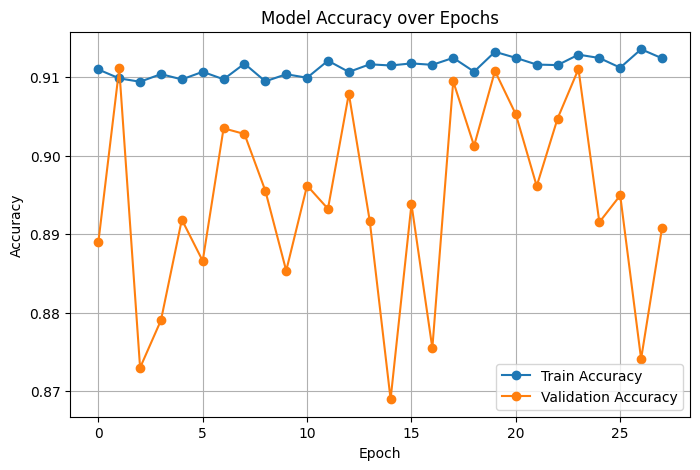

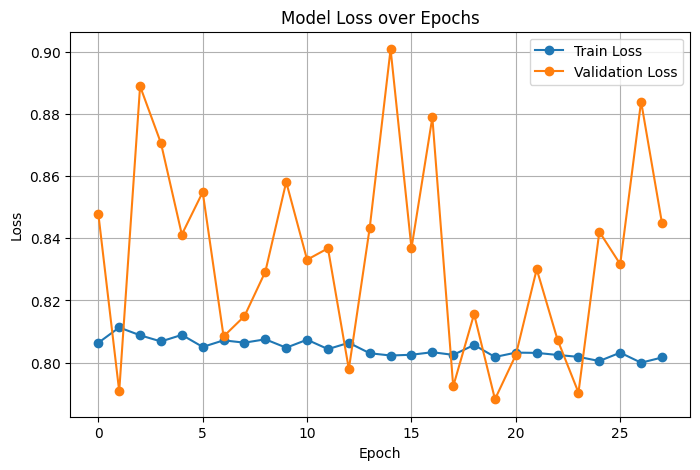

In [16]:
import matplotlib.pyplot as plt

# Plot Accuracy
plt.figure(figsize=(8,5))
plt.plot(history.history['accuracy'], label='Train Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='o')
plt.title('Model Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()
plt.show()

# Plot Loss
plt.figure(figsize=(8,5))
plt.plot(history.history['loss'], label='Train Loss', marker='o')
plt.plot(history.history['val_loss'], label='Validation Loss', marker='o')
plt.title('Model Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()
plt.show()


**Classification Report & Confusion Matrix**

475/475 ━━━━━━━━━━━━━━━━━━━━ 36s 74ms/step
Classification Report:

              precision    recall  f1-score   support

        BD30       0.80      0.95      0.87       400
        BD33       0.89      0.96      0.93       400
        BD39       0.99      0.99      0.99       400
        BD49       0.81      0.88      0.84       400
        BD51       0.96      0.94      0.95       400
        BD52       0.95      0.92      0.93       400
        BD56       0.92      0.90      0.91       400
        BD57       0.99      0.98      0.98       400
        BD70       0.97      0.92      0.94       400
        BD72       0.98      0.97      0.97       400
        BD75       0.89      0.85      0.87       400
        BD76       1.00      0.98      0.99       400
        BD79       0.91      0.90      0.91       400
        BD85       0.94      0.89      0.91       400
        BD87       0.99      0.99      0.99       400
        BD91       0.93      0.95      0.94       400
        BD93  

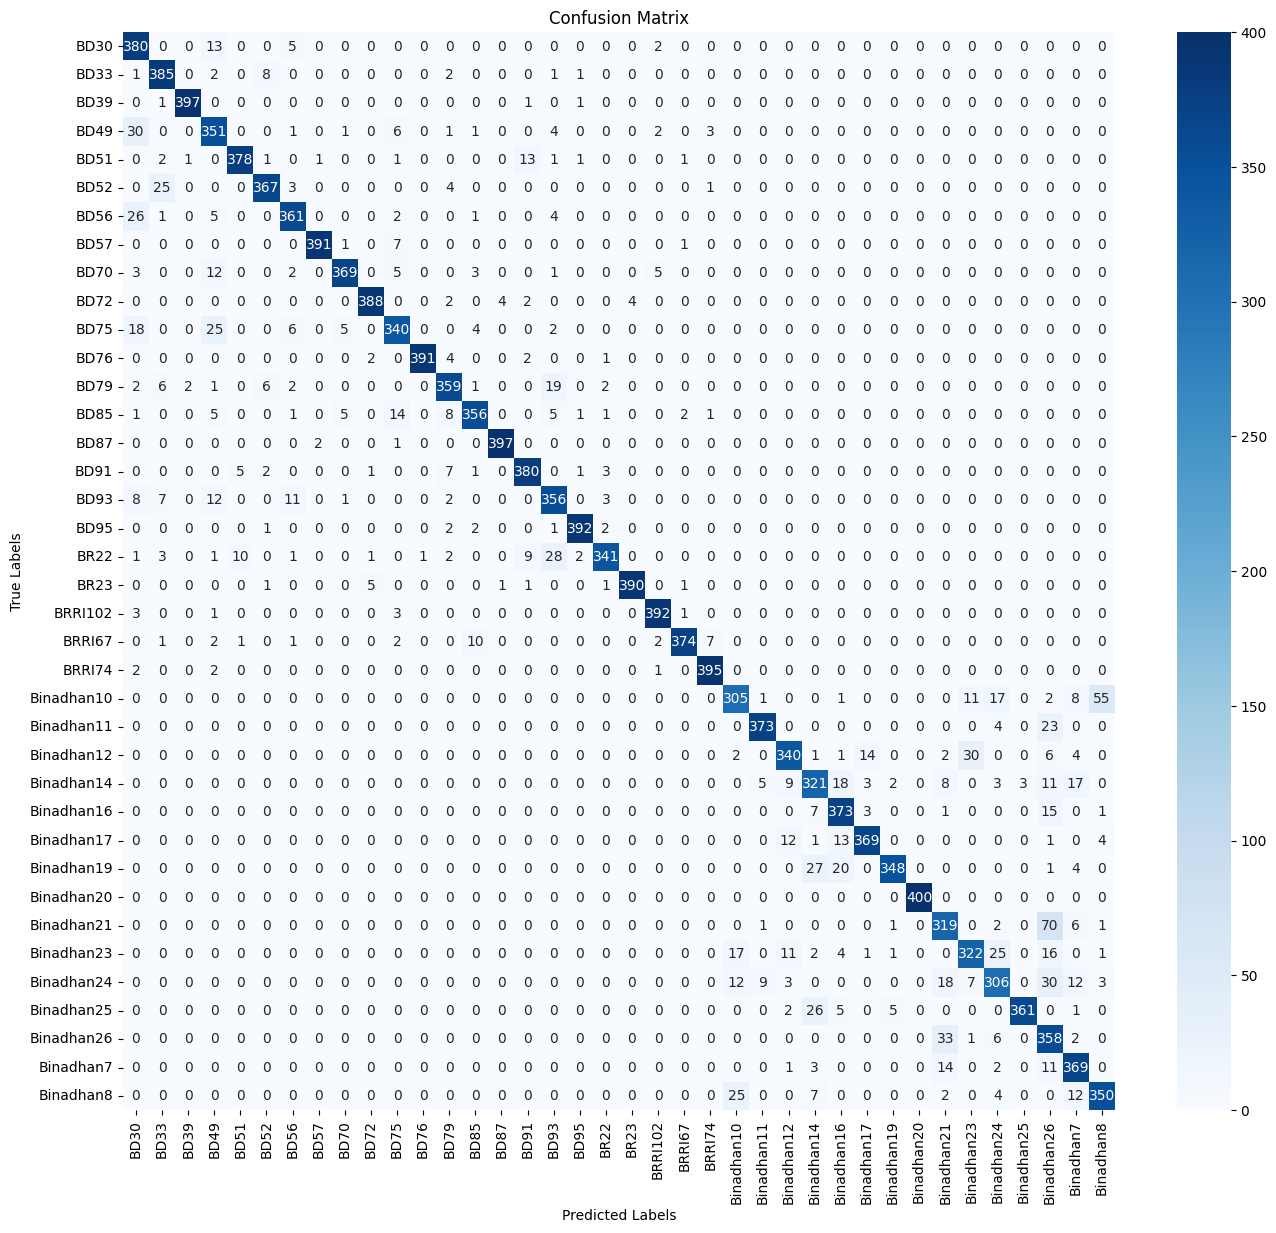

In [17]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Reset validation generator to start from first batch
val_gen.reset()

# Get predictions
pred_probs = model.predict(val_gen, verbose=1)
y_pred = np.argmax(pred_probs, axis=1)
y_true = val_gen.classes
class_labels = list(val_gen.class_indices.keys())

# Classification report (includes precision, recall, f1-score, support)
print("Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_labels))

# Confusion matrix (raw counts)
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix with values visible
plt.figure(figsize=(16,14))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels,
            yticklabels=class_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.show()


**ROC-AUC Curves:**

475/475 ━━━━━━━━━━━━━━━━━━━━ 33s 70ms/step


/tmp/ipykernel_36/2331452618.py:20: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab20', n_classes)


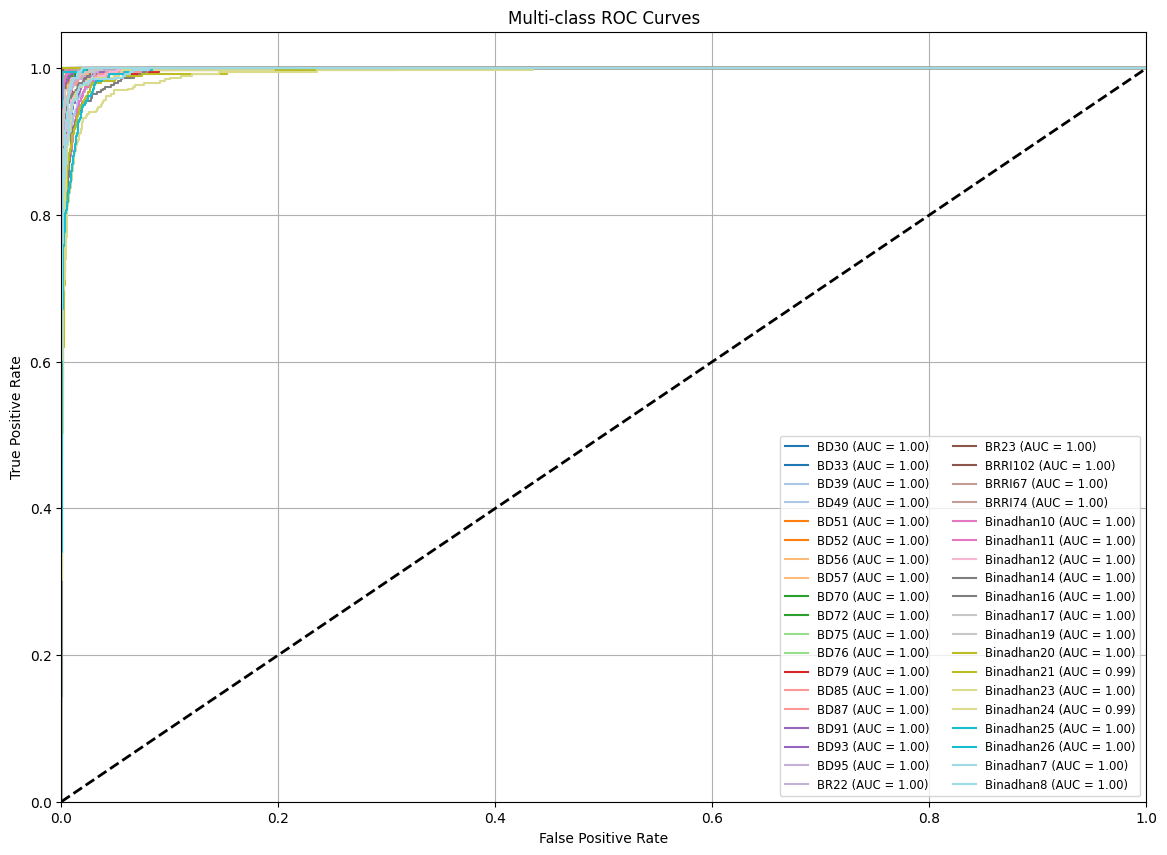

In [18]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import numpy as np

# Reset validation generator
val_gen.reset()

# True labels and predicted probabilities
y_true = val_gen.classes
y_score = model.predict(val_gen, verbose=1)  # shape (num_samples, num_classes)

# Binarize the true labels for multi-class ROC
n_classes = len(val_gen.class_indices)
y_true_bin = label_binarize(y_true, classes=range(n_classes))

# Plot ROC curve for each class
plt.figure(figsize=(14, 10))

colors = plt.cm.get_cmap('tab20', n_classes)

for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_score[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, color=colors(i),
             label=f'{list(val_gen.class_indices.keys())[i]} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)  # Diagonal line for random guess
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-class ROC Curves')
plt.legend(loc='lower right', fontsize='small', ncol=2)
plt.grid(True)
plt.show()


**Learning Curve**

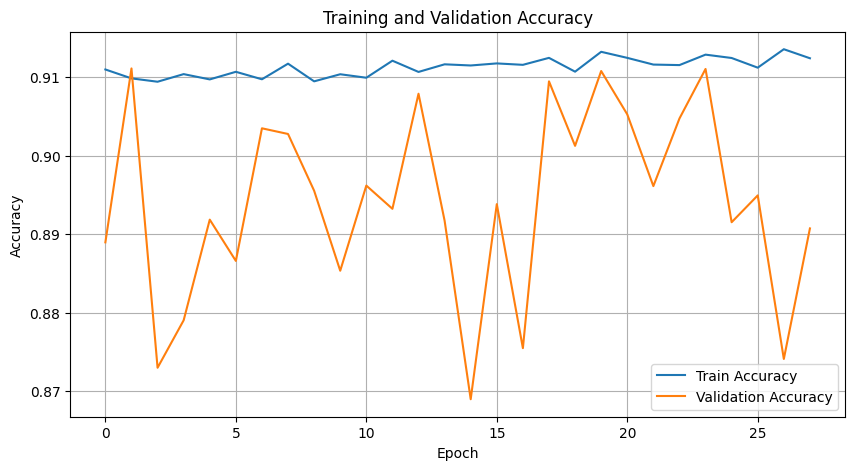

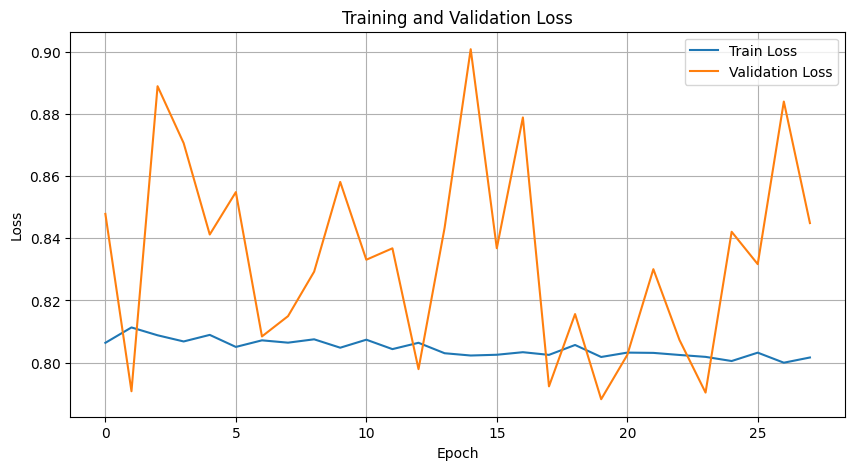

In [19]:
import matplotlib.pyplot as plt

def plot_learning_curves(history):
    # Accuracy plot
    plt.figure(figsize=(10,5))
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Loss plot
    plt.figure(figsize=(10,5))
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

# Call this function after training:
plot_learning_curves(history)


**Grad-CAM**

In [20]:
import os

dataset_dir = '/kaggle/input/rice-varieties-in-bangladesh/Augmented'

# List first 5 images from one class folder, e.g. 'BD87'
class_folder = os.path.join(dataset_dir, 'BD87')
image_files = os.listdir(class_folder)[:5]
for f in image_files:
    print(os.path.join(class_folder, f))


/kaggle/input/rice-varieties-in-bangladesh/Augmented/BD87/augmented_BD87 (1933).jpg
/kaggle/input/rice-varieties-in-bangladesh/Augmented/BD87/augmented_BD87 (400).jpg
/kaggle/input/rice-varieties-in-bangladesh/Augmented/BD87/augmented_BD87 (921).jpg
/kaggle/input/rice-varieties-in-bangladesh/Augmented/BD87/augmented_BD87 (297).jpg
/kaggle/input/rice-varieties-in-bangladesh/Augmented/BD87/augmented_BD87 (951).jpg


In [21]:
import os

dataset_dir = '/kaggle/input/rice-varieties-in-bangladesh/Augmented'

# Get all class folders inside dataset directory
class_folders = [f for f in os.listdir(dataset_dir) if os.path.isdir(os.path.join(dataset_dir, f))]

# To store one image path per class
sample_images = []

for class_name in class_folders:
    class_path = os.path.join(dataset_dir, class_name)
    images = [img for img in os.listdir(class_path) if img.lower().endswith(('.jpg', '.jpeg', '.png'))]
    
    if images:
        # Pick the first image (you can change this to random.choice(images) if you want)
        sample_img = images[0]
        sample_img_path = os.path.join(class_path, sample_img)
        sample_images.append((class_name, sample_img_path))
    else:
        print(f"No images found in class folder: {class_name}")

# Print all selected image paths
for class_name, img_path in sample_images:
    print(f"{class_name}: {img_path}")


BRRI67: /kaggle/input/rice-varieties-in-bangladesh/Augmented/BRRI67/augmented_BRRI67 (1375).jpg
Binadhan10: /kaggle/input/rice-varieties-in-bangladesh/Augmented/Binadhan10/augmented_Binadhan10 (3378).jpg
BD56: /kaggle/input/rice-varieties-in-bangladesh/Augmented/BD56/augmented_BD56 (1633).jpg
Binadhan17: /kaggle/input/rice-varieties-in-bangladesh/Augmented/Binadhan17/augmented_Binadhan17 (193).jpg
BD33: /kaggle/input/rice-varieties-in-bangladesh/Augmented/BD33/augmented_BD33 (1552).jpg
Binadhan23: /kaggle/input/rice-varieties-in-bangladesh/Augmented/Binadhan23/augmented_Binadhan23 (1926).jpg
BD75: /kaggle/input/rice-varieties-in-bangladesh/Augmented/BD75/augmented_BD75 (1559).jpg
BD49: /kaggle/input/rice-varieties-in-bangladesh/Augmented/BD49/augmented_BD49 (775).jpg
BRRI102: /kaggle/input/rice-varieties-in-bangladesh/Augmented/BRRI102/augmented_BRRI102 (214).jpg
BD72: /kaggle/input/rice-varieties-in-bangladesh/Augmented/BD72/augmented_BD72 (1652).jpg
Binadhan8: /kaggle/input/rice-vari

Processing: /kaggle/input/rice-varieties-in-bangladesh/Augmented/BRRI67/augmented_BRRI67 (1375).jpg


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['keras_tensor_39']]
Received: inputs=Tensor(shape=(1, 128, 128, 3))
  warnings.warn(msg)


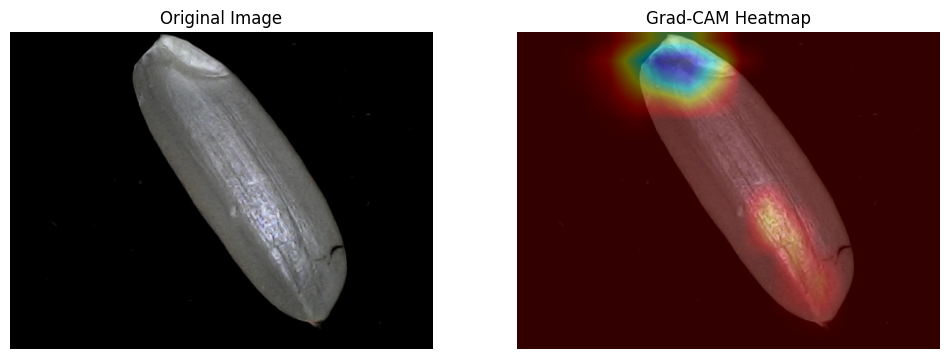

Processing: /kaggle/input/rice-varieties-in-bangladesh/Augmented/Binadhan10/augmented_Binadhan10 (3378).jpg


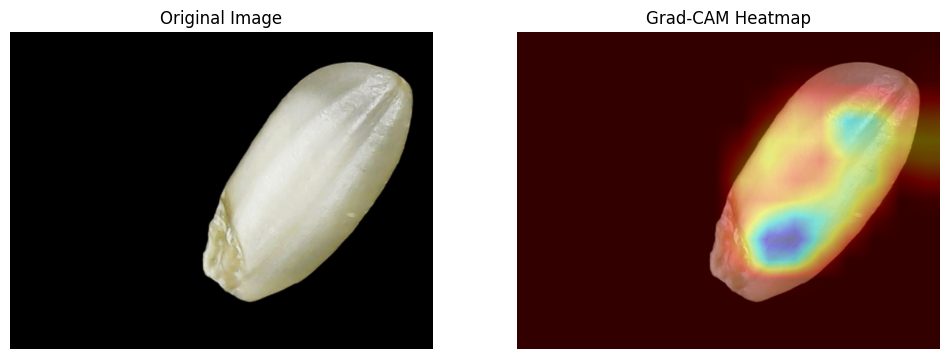

Processing: /kaggle/input/rice-varieties-in-bangladesh/Augmented/BD56/augmented_BD56 (1633).jpg


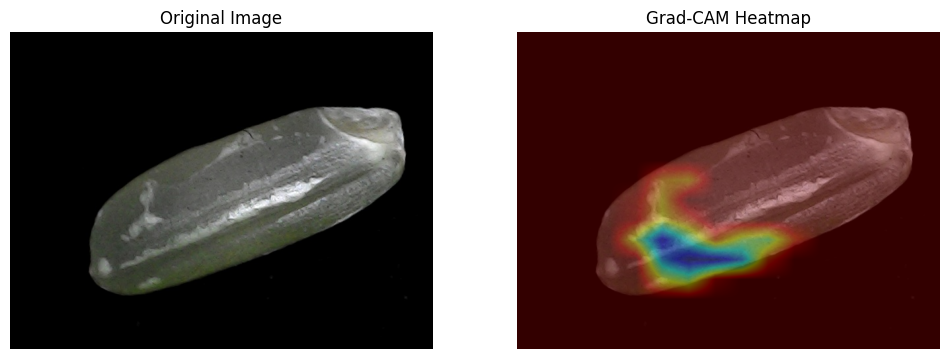

Processing: /kaggle/input/rice-varieties-in-bangladesh/Augmented/Binadhan17/augmented_Binadhan17 (193).jpg


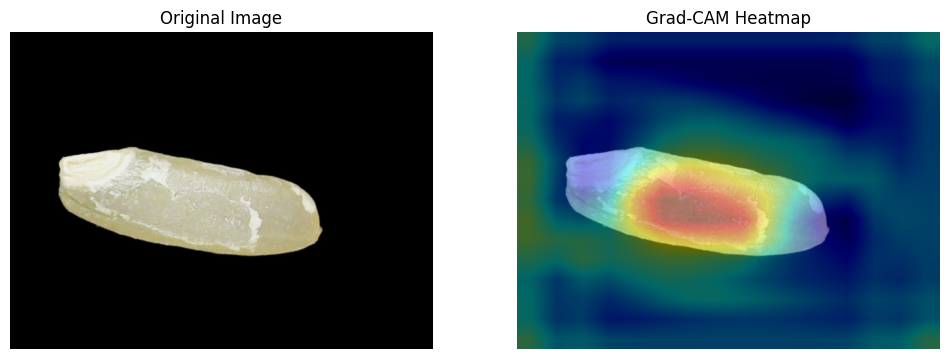

Processing: /kaggle/input/rice-varieties-in-bangladesh/Augmented/BD33/augmented_BD33 (1552).jpg


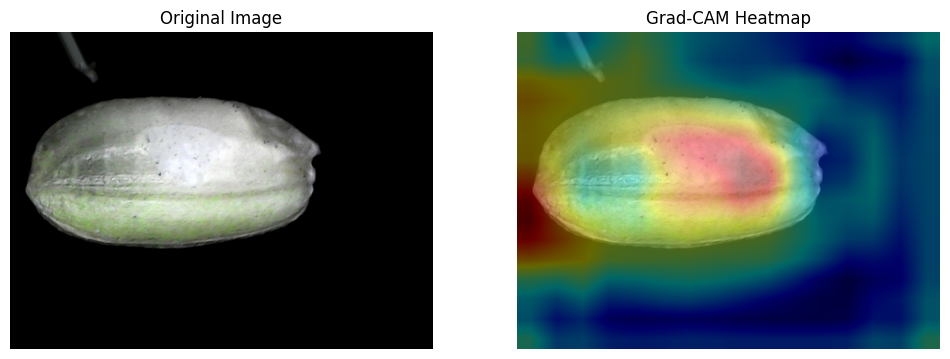

Processing: /kaggle/input/rice-varieties-in-bangladesh/Augmented/Binadhan23/augmented_Binadhan23 (1926).jpg


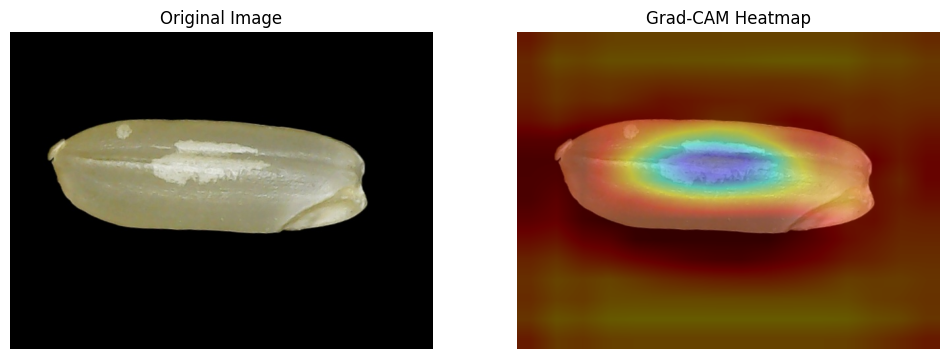

Processing: /kaggle/input/rice-varieties-in-bangladesh/Augmented/BD75/augmented_BD75 (1559).jpg


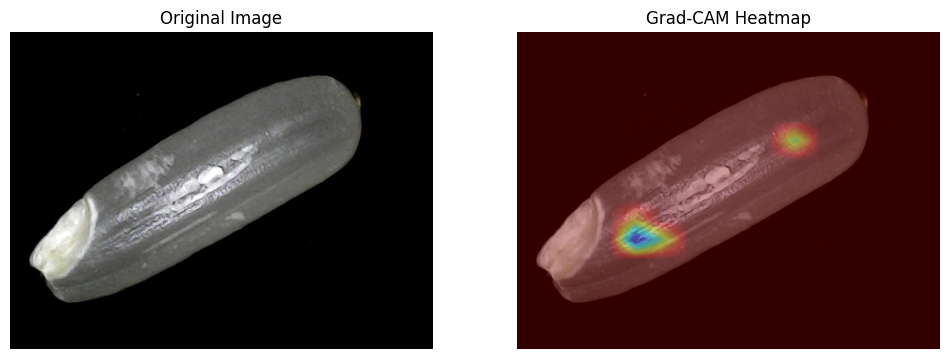

Processing: /kaggle/input/rice-varieties-in-bangladesh/Augmented/BD49/augmented_BD49 (775).jpg


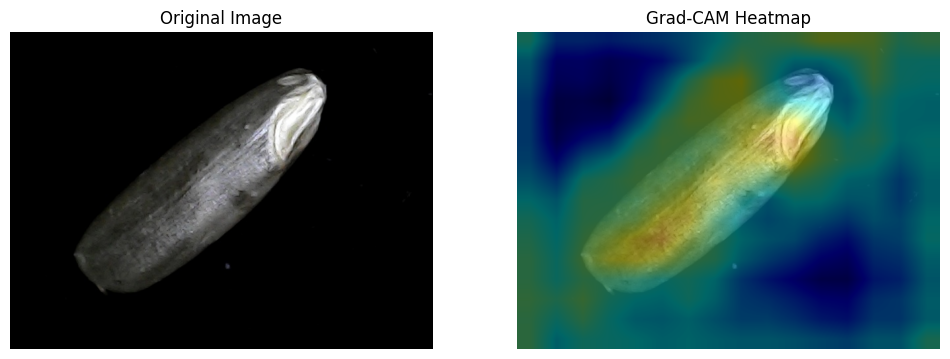

Processing: /kaggle/input/rice-varieties-in-bangladesh/Augmented/BRRI102/augmented_BRRI102 (214).jpg


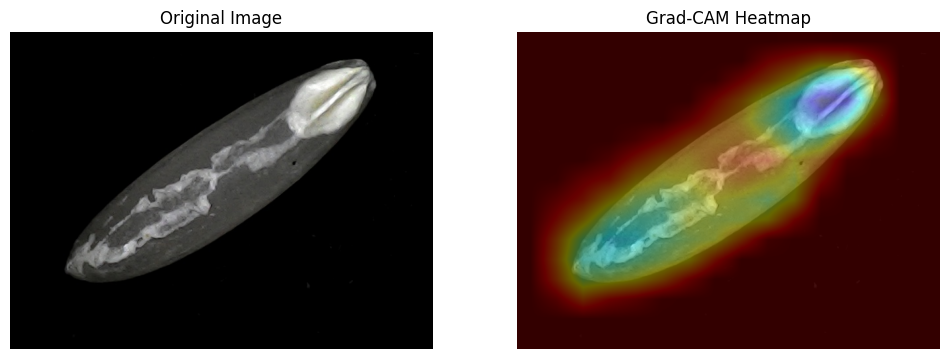

Processing: /kaggle/input/rice-varieties-in-bangladesh/Augmented/BD72/augmented_BD72 (1652).jpg


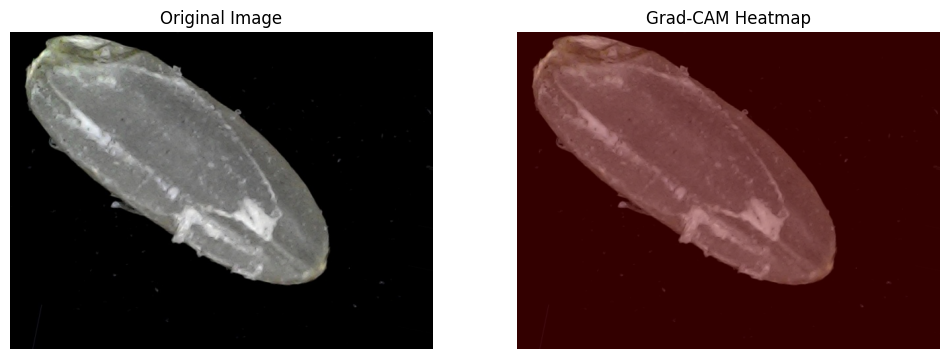

Processing: /kaggle/input/rice-varieties-in-bangladesh/Augmented/Binadhan8/augmented_Binadhan8 (691).jpg


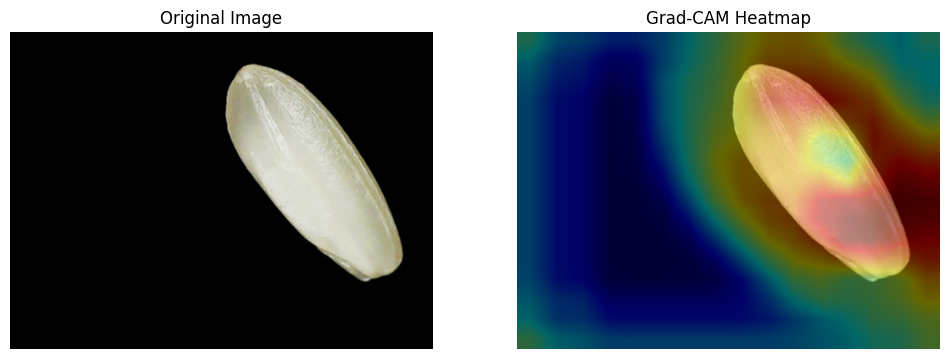

Processing: /kaggle/input/rice-varieties-in-bangladesh/Augmented/Binadhan20/augmented_Binadhan20 (967).jpg


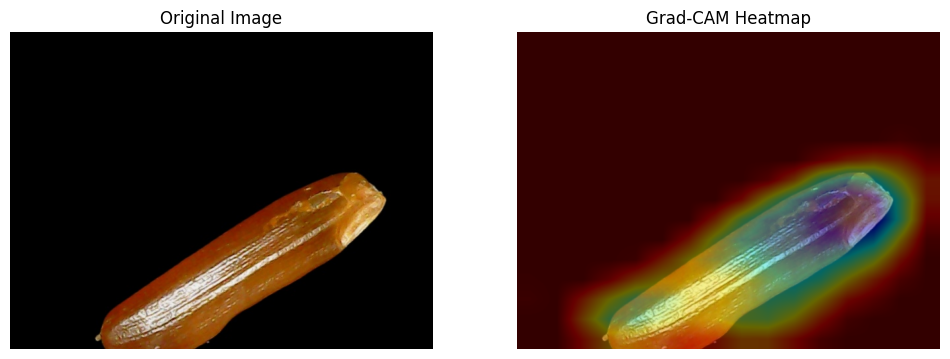

Processing: /kaggle/input/rice-varieties-in-bangladesh/Augmented/BD93/augmented_BD93 (1897).jpg


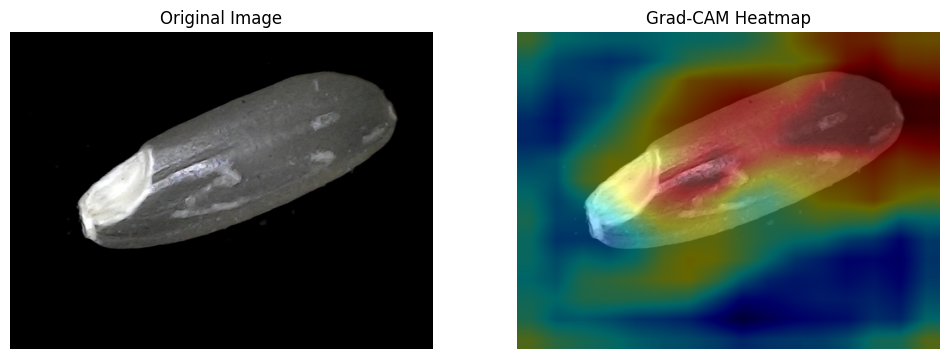

Processing: /kaggle/input/rice-varieties-in-bangladesh/Augmented/Binadhan12/augmented_Binadhan12 (1623).jpg


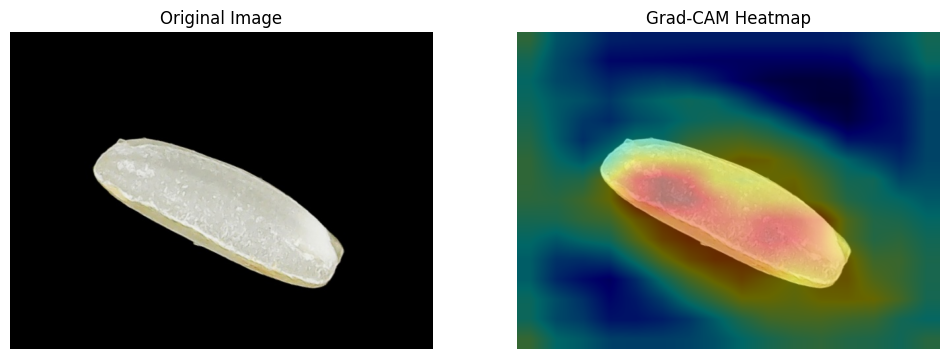

Processing: /kaggle/input/rice-varieties-in-bangladesh/Augmented/BD57/augmented_BD57 (1901).jpg


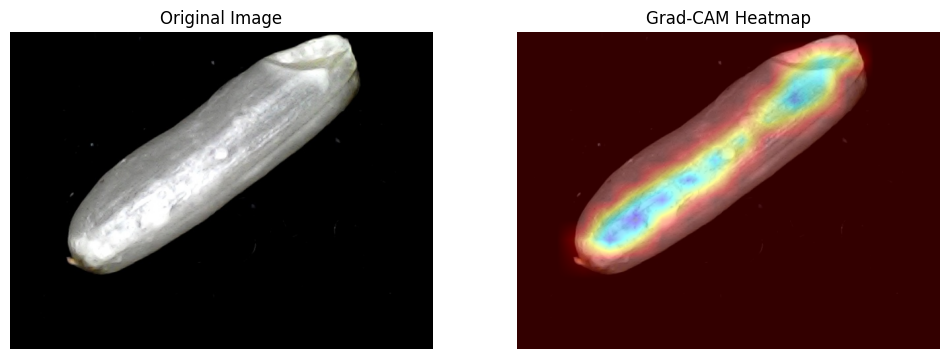

Processing: /kaggle/input/rice-varieties-in-bangladesh/Augmented/BD52/augmented_BD52 (1676).jpg


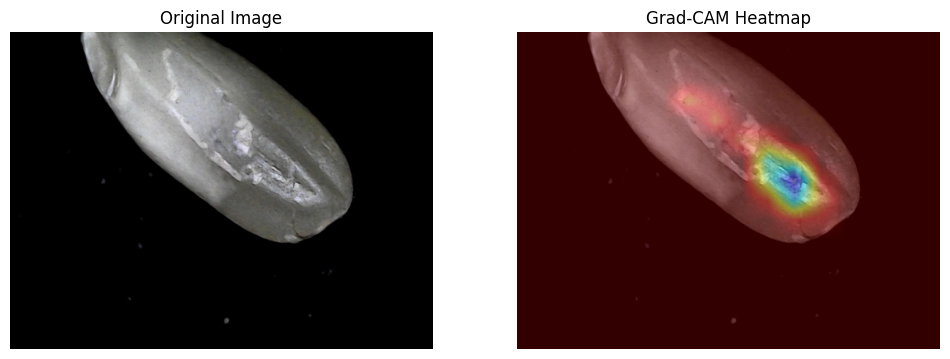

Processing: /kaggle/input/rice-varieties-in-bangladesh/Augmented/Binadhan7/augmented_Binadhan7 (1596).jpg


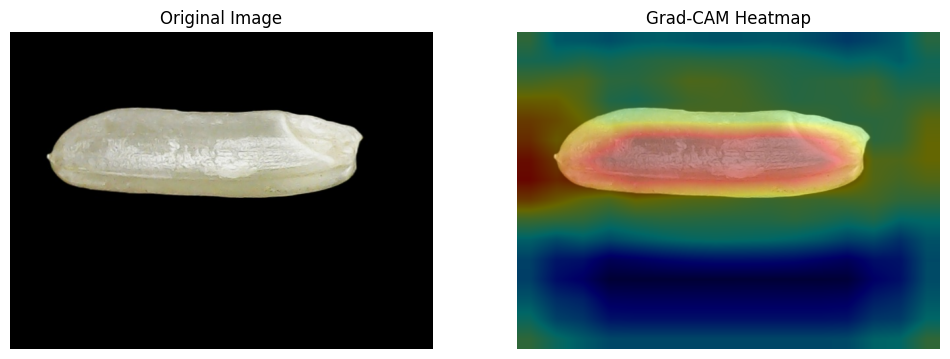

Processing: /kaggle/input/rice-varieties-in-bangladesh/Augmented/Binadhan16/augmented_Binadhan16 (1237).jpg


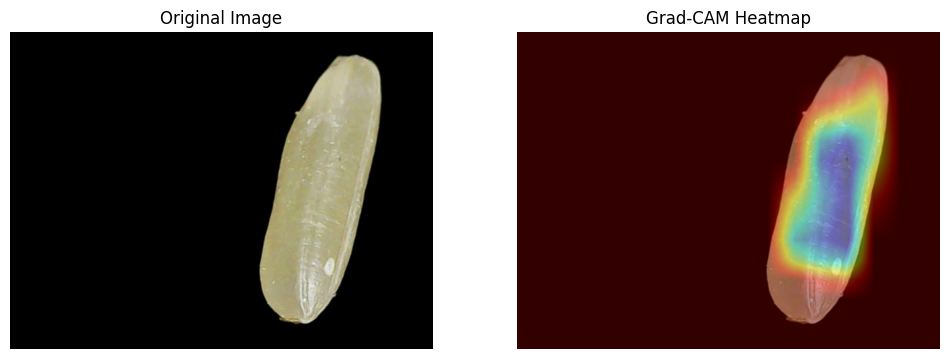

Processing: /kaggle/input/rice-varieties-in-bangladesh/Augmented/BD51/augmented_BD51 (2718).jpg


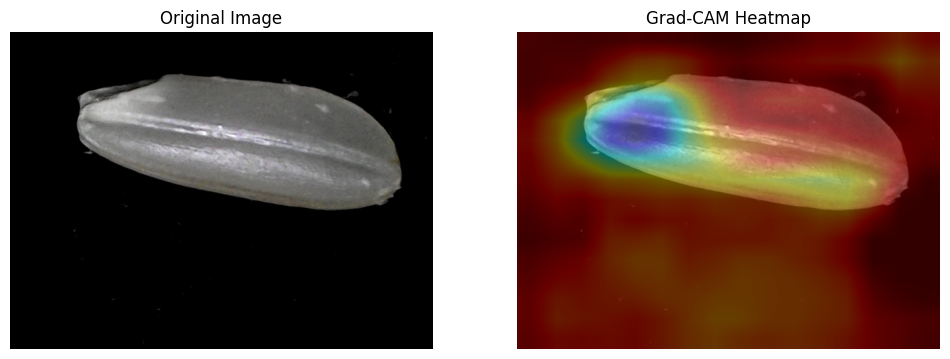

Processing: /kaggle/input/rice-varieties-in-bangladesh/Augmented/Binadhan25/augmented_Binadhan25 (624).jpg


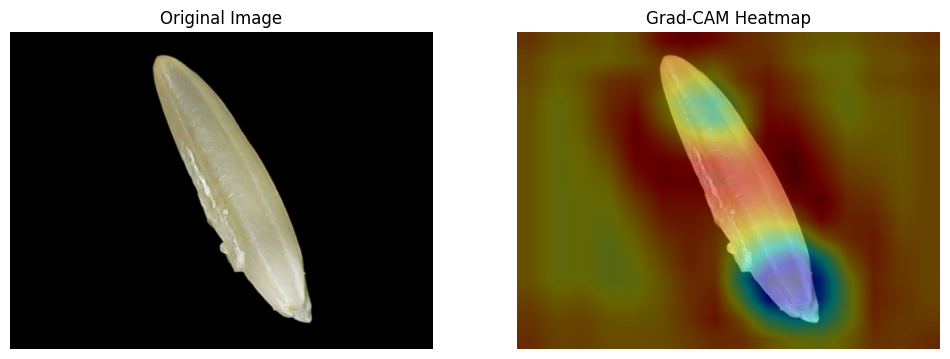

Processing: /kaggle/input/rice-varieties-in-bangladesh/Augmented/BD70/augmented_BD70 (814).jpg


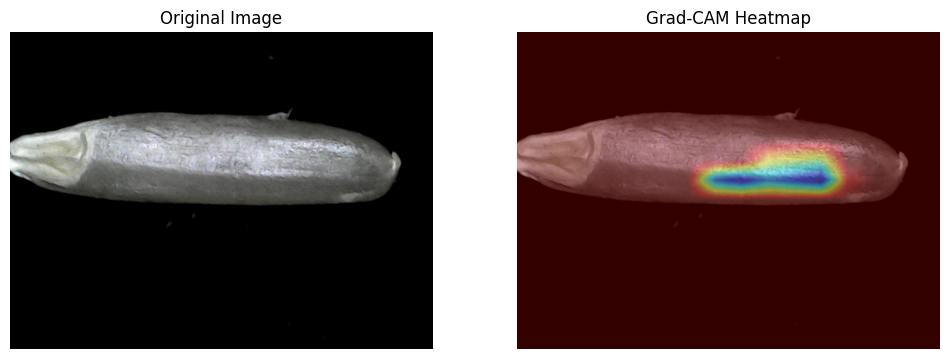

Processing: /kaggle/input/rice-varieties-in-bangladesh/Augmented/Binadhan24/augmented_Binadhan24 (108).jpg


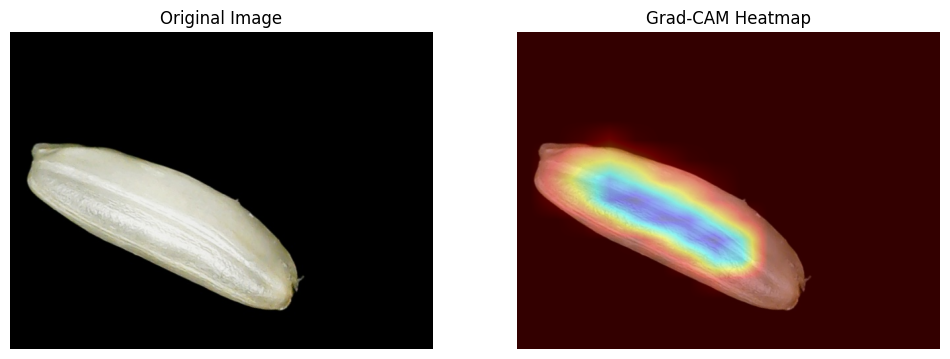

Processing: /kaggle/input/rice-varieties-in-bangladesh/Augmented/BD30/augmented_BD30 (1633).jpg


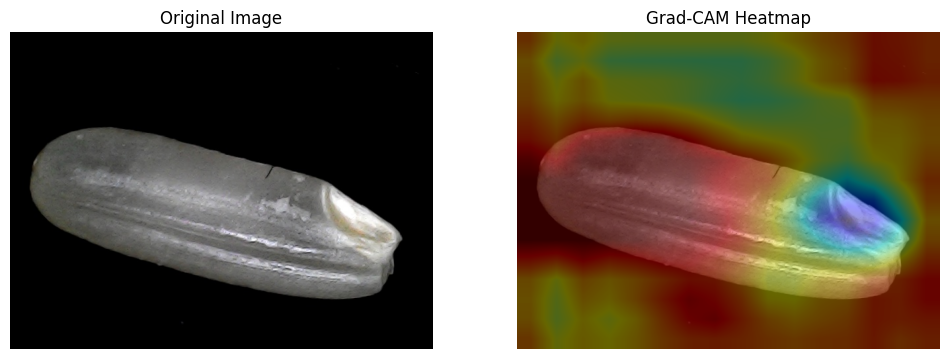

Processing: /kaggle/input/rice-varieties-in-bangladesh/Augmented/BR22/augmented_BR22 (228).jpg


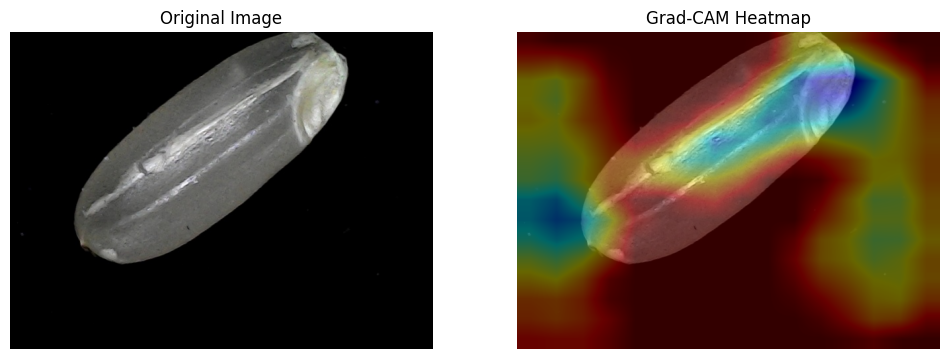

Processing: /kaggle/input/rice-varieties-in-bangladesh/Augmented/BD79/augmented_BD79 (1303).jpg


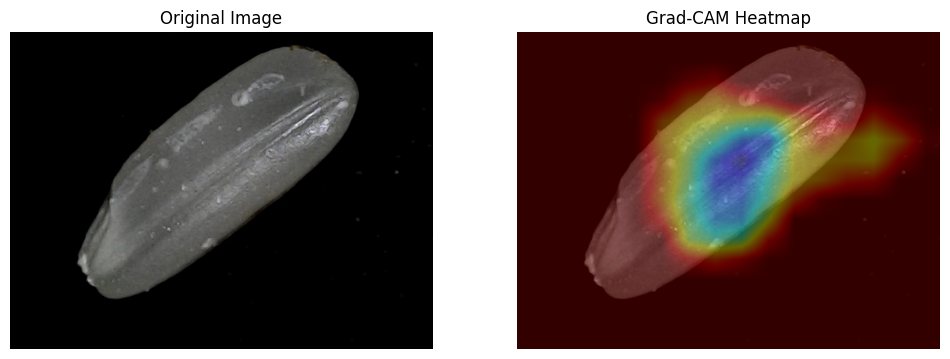

Processing: /kaggle/input/rice-varieties-in-bangladesh/Augmented/BD87/augmented_BD87 (1933).jpg


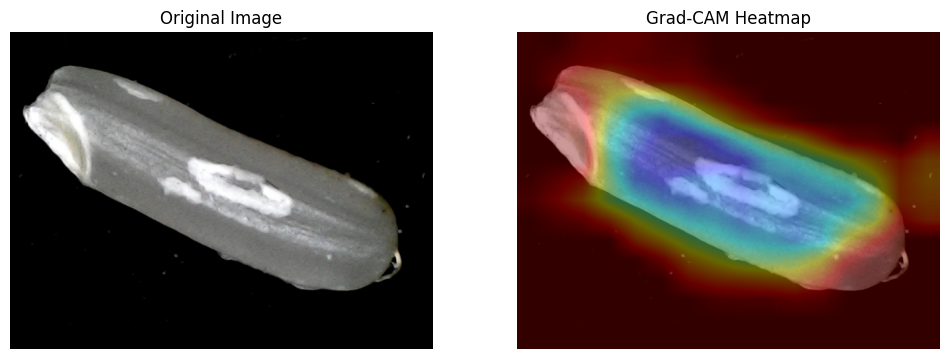

Processing: /kaggle/input/rice-varieties-in-bangladesh/Augmented/BD91/augmented_BD91 (387).jpg


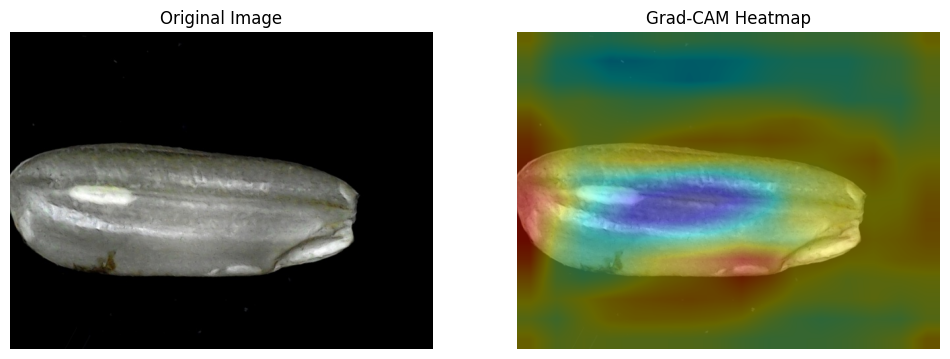

Processing: /kaggle/input/rice-varieties-in-bangladesh/Augmented/BD85/augmented_BD85 (1695).jpg


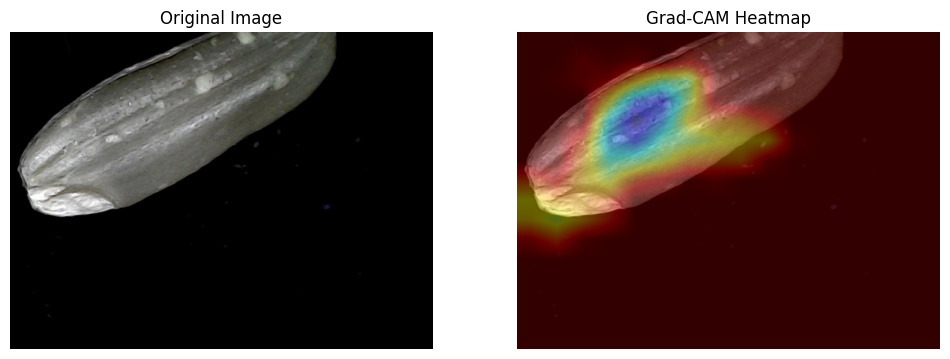

Processing: /kaggle/input/rice-varieties-in-bangladesh/Augmented/BR23/augmented_BR23 (964).jpg


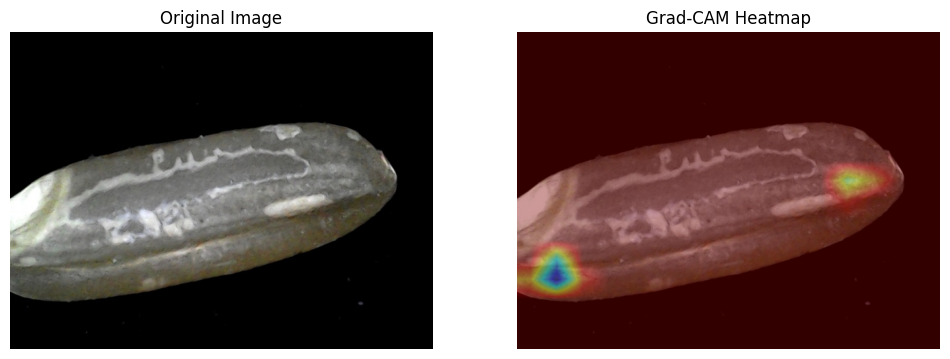

Processing: /kaggle/input/rice-varieties-in-bangladesh/Augmented/BD95/augmented_BD95 (634).jpg


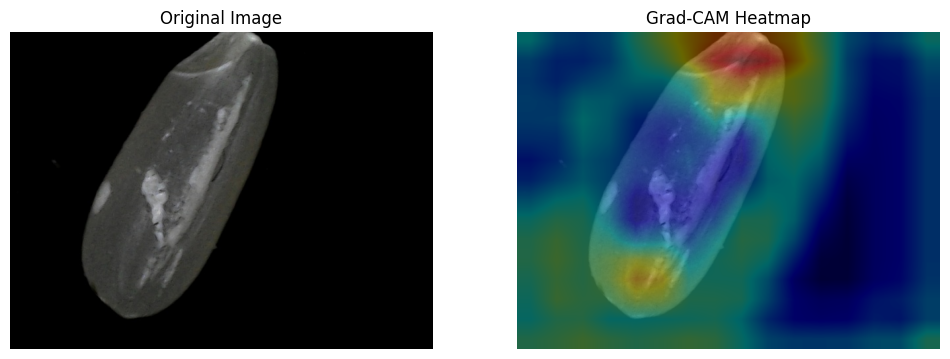

Processing: /kaggle/input/rice-varieties-in-bangladesh/Augmented/Binadhan11/augmented_Binadhan11 (1507).jpg


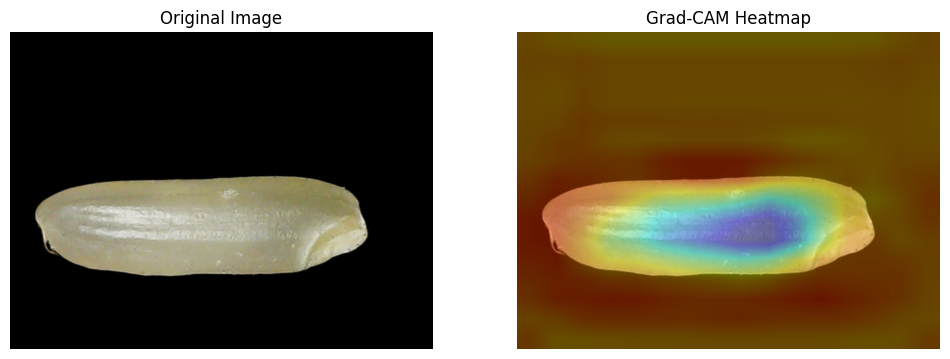

Processing: /kaggle/input/rice-varieties-in-bangladesh/Augmented/Binadhan26/augmented_Binadhan26 (569).jpg


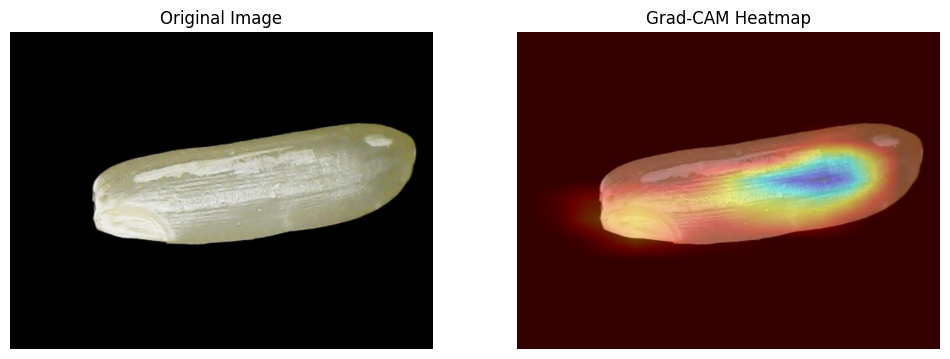

Processing: /kaggle/input/rice-varieties-in-bangladesh/Augmented/Binadhan19/augmented_Binadhan19 (302).jpg


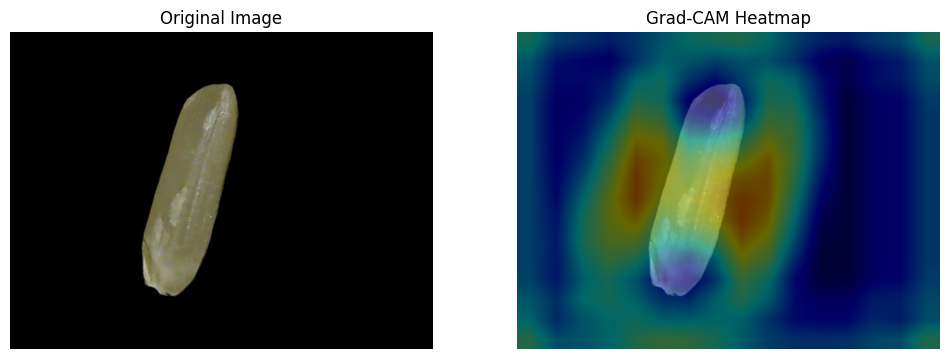

Processing: /kaggle/input/rice-varieties-in-bangladesh/Augmented/BD39/augmented_BD39 (132).jpg


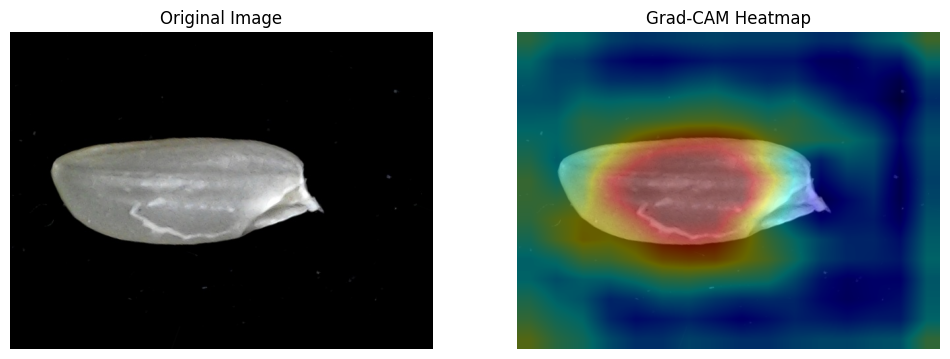

Processing: /kaggle/input/rice-varieties-in-bangladesh/Augmented/Binadhan14/augmented_Binadhan14 (62).jpg


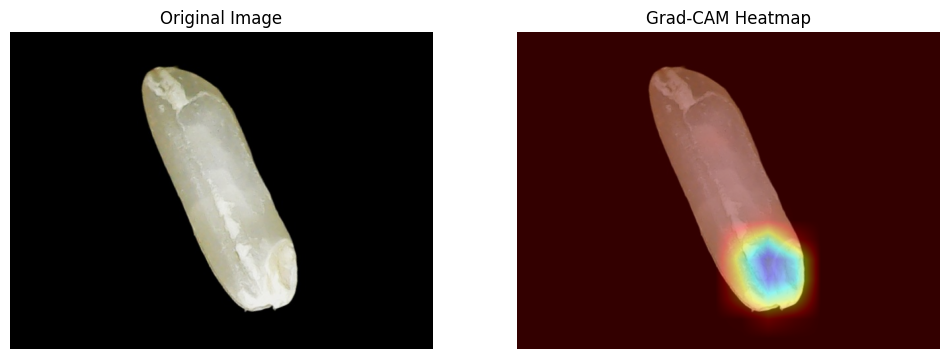

Processing: /kaggle/input/rice-varieties-in-bangladesh/Augmented/Binadhan21/augmented_Binadhan21 (172).jpg


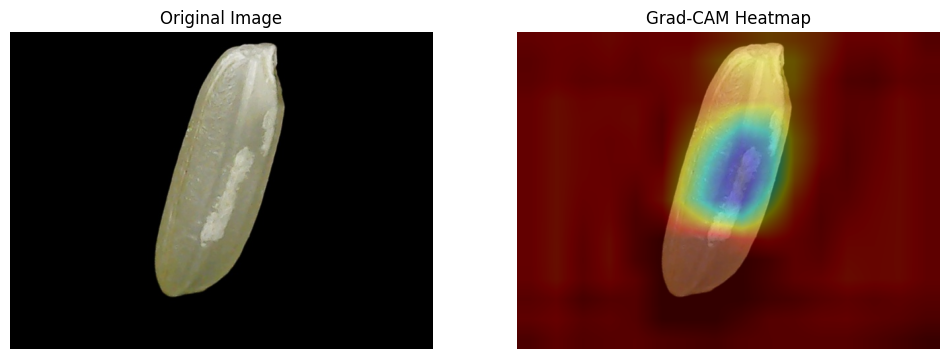

Processing: /kaggle/input/rice-varieties-in-bangladesh/Augmented/BRRI74/augmented_BRRI74 (1156).jpg


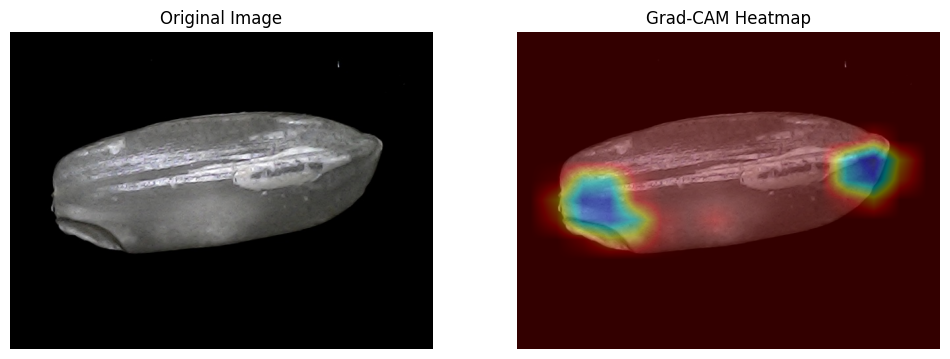

Processing: /kaggle/input/rice-varieties-in-bangladesh/Augmented/BD76/augmented_BD76 (1593).jpg


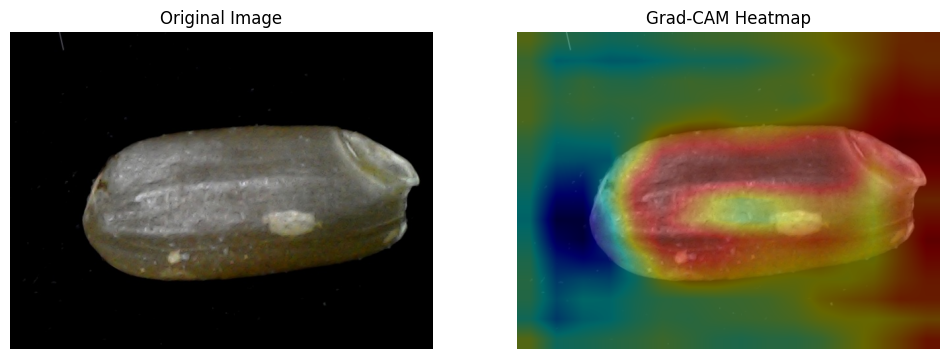

In [23]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import cv2

def get_img_array(img_path, size):
    """Load and preprocess image."""
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=size)
    array = tf.keras.preprocessing.image.img_to_array(img)
    array = np.expand_dims(array, axis=0)
    array = array / 255.0  # normalize as during training
    return array

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model = tf.keras.models.Model(
        [model.inputs], 
        [model.get_layer(last_conv_layer_name).output, model.output]
    )
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(predictions[0])
        class_channel = predictions[:, pred_index]
    grads = tape.gradient(class_channel, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

def display_gradcam_side_by_side(img_path, heatmap, alpha=0.4):
    # Load original image
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    heatmap_resized = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap_uint8 = np.uint8(255 * heatmap_resized)
    heatmap_color = cv2.applyColorMap(heatmap_uint8, cv2.COLORMAP_JET)
    superimposed_img = cv2.addWeighted(heatmap_color, alpha, img, 1 - alpha, 0)

    plt.figure(figsize=(12,6))
    plt.subplot(1,2,1)
    plt.title('Original Image')
    plt.imshow(img)
    plt.axis('off')

    plt.subplot(1,2,2)
    plt.title('Grad-CAM Heatmap')
    plt.imshow(superimposed_img)
    plt.axis('off')

    plt.show()

# ==== USAGE ====

last_conv_layer_name = "conv2d_15"  # Replace with your actual last conv layer name

# List of 32 image paths, for example:
image_paths = [
    "/kaggle/input/rice-varieties-in-bangladesh/Augmented/BRRI67/augmented_BRRI67 (1375).jpg",
    "/kaggle/input/rice-varieties-in-bangladesh/Augmented/Binadhan10/augmented_Binadhan10 (3378).jpg",
    "/kaggle/input/rice-varieties-in-bangladesh/Augmented/BD56/augmented_BD56 (1633).jpg",
    "/kaggle/input/rice-varieties-in-bangladesh/Augmented/Binadhan17/augmented_Binadhan17 (193).jpg",
    "/kaggle/input/rice-varieties-in-bangladesh/Augmented/BD33/augmented_BD33 (1552).jpg",
    "/kaggle/input/rice-varieties-in-bangladesh/Augmented/Binadhan23/augmented_Binadhan23 (1926).jpg",
    "/kaggle/input/rice-varieties-in-bangladesh/Augmented/BD75/augmented_BD75 (1559).jpg",
    "/kaggle/input/rice-varieties-in-bangladesh/Augmented/BD49/augmented_BD49 (775).jpg",
    "/kaggle/input/rice-varieties-in-bangladesh/Augmented/BRRI102/augmented_BRRI102 (214).jpg",
    "/kaggle/input/rice-varieties-in-bangladesh/Augmented/BD72/augmented_BD72 (1652).jpg",
    "/kaggle/input/rice-varieties-in-bangladesh/Augmented/Binadhan8/augmented_Binadhan8 (691).jpg",
    "/kaggle/input/rice-varieties-in-bangladesh/Augmented/Binadhan20/augmented_Binadhan20 (967).jpg",
    "/kaggle/input/rice-varieties-in-bangladesh/Augmented/BD93/augmented_BD93 (1897).jpg",
    "/kaggle/input/rice-varieties-in-bangladesh/Augmented/Binadhan12/augmented_Binadhan12 (1623).jpg",
    "/kaggle/input/rice-varieties-in-bangladesh/Augmented/BD57/augmented_BD57 (1901).jpg",
    "/kaggle/input/rice-varieties-in-bangladesh/Augmented/BD52/augmented_BD52 (1676).jpg",
    "/kaggle/input/rice-varieties-in-bangladesh/Augmented/Binadhan7/augmented_Binadhan7 (1596).jpg",
    "/kaggle/input/rice-varieties-in-bangladesh/Augmented/Binadhan16/augmented_Binadhan16 (1237).jpg",
    "/kaggle/input/rice-varieties-in-bangladesh/Augmented/BD51/augmented_BD51 (2718).jpg",
    "/kaggle/input/rice-varieties-in-bangladesh/Augmented/Binadhan25/augmented_Binadhan25 (624).jpg",
    "/kaggle/input/rice-varieties-in-bangladesh/Augmented/BD70/augmented_BD70 (814).jpg",
    "/kaggle/input/rice-varieties-in-bangladesh/Augmented/Binadhan24/augmented_Binadhan24 (108).jpg",
    "/kaggle/input/rice-varieties-in-bangladesh/Augmented/BD30/augmented_BD30 (1633).jpg",
    "/kaggle/input/rice-varieties-in-bangladesh/Augmented/BR22/augmented_BR22 (228).jpg",
    "/kaggle/input/rice-varieties-in-bangladesh/Augmented/BD79/augmented_BD79 (1303).jpg",
    "/kaggle/input/rice-varieties-in-bangladesh/Augmented/BD87/augmented_BD87 (1933).jpg",
    "/kaggle/input/rice-varieties-in-bangladesh/Augmented/BD91/augmented_BD91 (387).jpg",
    "/kaggle/input/rice-varieties-in-bangladesh/Augmented/BD85/augmented_BD85 (1695).jpg",
    "/kaggle/input/rice-varieties-in-bangladesh/Augmented/BR23/augmented_BR23 (964).jpg",
    "/kaggle/input/rice-varieties-in-bangladesh/Augmented/BD95/augmented_BD95 (634).jpg",
    "/kaggle/input/rice-varieties-in-bangladesh/Augmented/Binadhan11/augmented_Binadhan11 (1507).jpg",
    "/kaggle/input/rice-varieties-in-bangladesh/Augmented/Binadhan26/augmented_Binadhan26 (569).jpg",
    "/kaggle/input/rice-varieties-in-bangladesh/Augmented/Binadhan19/augmented_Binadhan19 (302).jpg",
    "/kaggle/input/rice-varieties-in-bangladesh/Augmented/BD39/augmented_BD39 (132).jpg",
    "/kaggle/input/rice-varieties-in-bangladesh/Augmented/Binadhan14/augmented_Binadhan14 (62).jpg",
    "/kaggle/input/rice-varieties-in-bangladesh/Augmented/Binadhan21/augmented_Binadhan21 (172).jpg",
    "/kaggle/input/rice-varieties-in-bangladesh/Augmented/BRRI74/augmented_BRRI74 (1156).jpg",
    "/kaggle/input/rice-varieties-in-bangladesh/Augmented/BD76/augmented_BD76 (1593).jpg",
]


for img_path in image_paths:
    print(f"Processing: {img_path}")
    img_array = get_img_array(img_path, size=(128, 128))  # use your IMG_SIZE
    heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)
    display_gradcam_side_by_side(img_path, heatmap, alpha=0.4)


# to build a hybrid model that:

Uses trained CNN as a feature extractor (remove the final classification layer).

Extracts feature vectors from dataset images.

Trains different classic ML classifiers (SVM, k-NN, Random Forest, XGBoost) on these extracted features.

Evaluates all classifiers thoroughly (accuracy, precision, recall, F1, confusion matrix, ROC/AUC, training/testing time).

Compares these results to the baseline CNN.

In [24]:
print(model.summary())


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_9 (Activation)       │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 128, 128, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_10 (Activation)      │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_11 (Activation)      │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 64, 64, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_12 (Activation)      │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_13 (Activation)      │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 32, 32, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │             

 Total params: 3,981,780 (15.19 MB)

 Trainable params: 1,326,278 (5.06 MB)

 Non-trainable params: 2,944 (11.50 KB)

 Optimizer params: 2,652,558 (10.12 MB)

None


In [25]:
feature_extractor = tf.keras.Model(inputs=model.input, outputs=model.layers[-3].output)
# Here model.layers[-3] should correspond to the 512-unit dense layer (adjust index as needed)


In [27]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

DATASET_PATH = "/kaggle/input/rice-varieties-in-bangladesh/Augmented"
IMG_SIZE = 128
BATCH_SIZE = 32

datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

train_generator = datagen.flow_from_directory(
    DATASET_PATH,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training'
)

val_generator = datagen.flow_from_directory(
    DATASET_PATH,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation'
)


Found 60800 images belonging to 38 classes.
Found 15200 images belonging to 38 classes.


In [29]:
feature_extractor = tf.keras.models.Model(
    inputs=model.input,
    outputs=model.get_layer('global_average_pooling2d_1').output
)


In [30]:
train_features, train_labels = extract_features(train_generator, feature_extractor)
val_features, val_labels = extract_features(val_generator, feature_extractor)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 751ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━

In [40]:
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve
import time


In [42]:
def train_and_evaluate(clf, X_train, y_train, X_test, y_test, classifier_name):
    print(f"\nTraining {classifier_name}...")
    start_train = time.time()
    clf.fit(X_train, y_train)
    end_train = time.time()

    print(f"Predicting with {classifier_name}...")
    start_test = time.time()
    y_pred = clf.predict(X_test)
    end_test = time.time()

    acc = accuracy_score(y_test, y_pred)
    print(f"{classifier_name} Accuracy: {acc:.4f}")
    print(f"Training time: {end_train - start_train:.2f} seconds")
    print(f"Testing time: {end_test - start_test:.2f} seconds")

    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))

    cm = confusion_matrix(y_test, y_pred)
    print("Confusion Matrix:")
    print(cm)

    # For ROC AUC, need predicted probabilities or decision function
    if hasattr(clf, "predict_proba"):
        y_prob = clf.predict_proba(X_test)
    elif hasattr(clf, "decision_function"):
        y_prob = clf.decision_function(X_test)
        # For binary, shape is (n_samples,), convert to 2d:
        if len(y_prob.shape) == 1:
            y_prob = np.vstack([1 - y_prob, y_prob]).T
    else:
        y_prob = None

    if y_prob is not None:
        # For multi-class ROC-AUC you can compute per class or macro average:
        try:
            roc_auc = roc_auc_score(y_test, y_prob, multi_class='ovo', average='macro')
            print(f"ROC AUC Score (macro-avg): {roc_auc:.4f}")

            # Optional: plot ROC curves per class here if you want
        except Exception as e:
            print(f"ROC AUC could not be computed: {e}")
    else:
        print("No probability estimates available for ROC AUC.")

    return clf


In [43]:
train_labels_indices = np.argmax(train_labels, axis=1)
val_labels_indices = np.argmax(val_labels, axis=1)


In [45]:
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report

# Define classifiers
svm_clf = SVC(kernel='linear', probability=True)
knn_clf = KNeighborsClassifier(n_neighbors=5)
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)
xgb_clf = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')

# Train & evaluate function
def train_and_evaluate(clf, X_train, y_train, X_val, y_val, model_name):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_val)
    acc = accuracy_score(y_val, y_pred)
    print(f"{model_name} Accuracy: {acc:.4f}")
    print(classification_report(y_val, y_pred))
    return clf


In [46]:
svm_clf = train_and_evaluate(svm_clf, train_features, train_labels_indices, val_features, val_labels_indices, "SVM")
knn_clf = train_and_evaluate(knn_clf, train_features, train_labels_indices, val_features, val_labels_indices, "KNN")
rf_clf = train_and_evaluate(rf_clf, train_features, train_labels_indices, val_features, val_labels_indices, "Random Forest")
xgb_clf = train_and_evaluate(xgb_clf, train_features, train_labels_indices, val_features, val_labels_indices, "XGBoost")

SVM Accuracy: 0.9487
              precision    recall  f1-score   support

           0       0.92      0.94      0.93       400
           1       0.97      0.96      0.97       400
           2       1.00      1.00      1.00       400
           3       0.91      0.91      0.91       400
           4       0.97      0.98      0.97       400
           5       0.95      0.96      0.96       400
           6       0.96      0.93      0.94       400
           7       1.00      1.00      1.00       400
           8       0.96      0.98      0.97       400
           9       0.99      0.98      0.99       400
          10       0.91      0.92      0.92       400
          11       1.00      1.00      1.00       400
          12       0.95      0.93      0.94       400
          13       0.95      0.93      0.94       400
          14       0.99      1.00      0.99       400
          15       0.97      0.97      0.97       400
          16       0.93      0.93      0.93       400
      

# Attention Mechanism

**Squeeze-and-Excitation (SE) Block**

In [47]:
from tensorflow.keras import layers

def se_block(input_tensor, reduction=16):
    channels = input_tensor.shape[-1]
    se = layers.GlobalAveragePooling2D()(input_tensor)
    se = layers.Dense(channels // reduction, activation='relu')(se)
    se = layers.Dense(channels, activation='sigmoid')(se)
    se = layers.Reshape((1,1,channels))(se)
    x = layers.Multiply()([input_tensor, se])
    return x


**Convolutional Block Attention Module (CBAM)**

In [48]:
def channel_attention(input_feature, ratio=8):
    channel = input_feature.shape[-1]
    shared_dense_one = layers.Dense(channel // ratio, activation='relu', kernel_initializer='he_normal', use_bias=True)
    shared_dense_two = layers.Dense(channel, kernel_initializer='he_normal', use_bias=True)

    avg_pool = layers.GlobalAveragePooling2D()(input_feature)
    avg_pool = layers.Reshape((1,1,channel))(avg_pool)
    avg_pool = shared_dense_one(avg_pool)
    avg_pool = shared_dense_two(avg_pool)

    max_pool = layers.GlobalMaxPooling2D()(input_feature)
    max_pool = layers.Reshape((1,1,channel))(max_pool)
    max_pool = shared_dense_one(max_pool)
    max_pool = shared_dense_two(max_pool)

    cbam_feature = layers.Add()([avg_pool, max_pool])
    cbam_feature = layers.Activation('sigmoid')(cbam_feature)

    return layers.Multiply()([input_feature, cbam_feature])

def spatial_attention(input_feature):
    kernel_size = 7
    avg_pool = layers.Lambda(lambda x: tf.reduce_mean(x, axis=3, keepdims=True))(input_feature)
    max_pool = layers.Lambda(lambda x: tf.reduce_max(x, axis=3, keepdims=True))(input_feature)
    concat = layers.Concatenate(axis=3)([avg_pool, max_pool])
    cbam_feature = layers.Conv2D(filters=1, kernel_size=kernel_size, strides=1, padding='same',
                                 activation='sigmoid', kernel_initializer='he_normal', use_bias=False)(concat)
    return layers.Multiply()([input_feature, cbam_feature])

def cbam_block(cbam_feature, ratio=8):
    cbam_feature = channel_attention(cbam_feature, ratio)
    cbam_feature = spatial_attention(cbam_feature)
    return cbam_feature


**Integrate into our conv_block**

In [50]:
def conv_block_with_cbam(x, filters, kernel_size=3, pool=True, dropout=0.15):
    x = layers.Conv2D(filters, kernel_size, padding='same',
                      kernel_regularizer=regularizers.l2(L2))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Conv2D(filters, kernel_size, padding='same',
                      kernel_regularizer=regularizers.l2(L2))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    
    # Insert attention here
    x = cbam_block(x)
    
    if pool:
        x = layers.MaxPooling2D((2,2))(x)
    if dropout and dropout > 0:
        x = layers.Dropout(dropout)(x)
    return x


In [51]:
inp = Input(shape=(IMG_SIZE, IMG_SIZE, 3))
x = conv_block_with_cbam(inp, 32, dropout=0.1)   # or conv_block_with_se(...)
x = conv_block_with_cbam(x, 64, dropout=0.15)
x = conv_block_with_cbam(x, 128, dropout=0.2)
x = conv_block_with_cbam(x, 256, dropout=0.25)

x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(512, kernel_regularizer=regularizers.l2(L2))(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)
x = layers.Dropout(0.5)(x)

out = layers.Dense(NUM_CLASSES, activation='softmax')(x)
model = Model(inp, out)


In [52]:
import time
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, regularizers, Model, Input
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from sklearn.utils.class_weight import compute_class_weight


In [53]:
# CBAM components 
def channel_attention(input_feature, ratio=8):
    channel = input_feature.shape[-1]
    shared_layer_one = layers.Dense(channel//ratio, activation='relu', kernel_initializer='he_normal', use_bias=True)
    shared_layer_two = layers.Dense(channel, kernel_initializer='he_normal', use_bias=True)

    avg_pool = layers.GlobalAveragePooling2D()(input_feature)
    avg_pool = layers.Reshape((1,1,channel))(avg_pool)
    avg_pool = shared_layer_one(avg_pool)
    avg_pool = shared_layer_two(avg_pool)

    max_pool = layers.GlobalMaxPooling2D()(input_feature)
    max_pool = layers.Reshape((1,1,channel))(max_pool)
    max_pool = shared_layer_one(max_pool)
    max_pool = shared_layer_two(max_pool)

    cbam_feature = layers.Add()([avg_pool, max_pool])
    cbam_feature = layers.Activation('sigmoid')(cbam_feature)
    return layers.Multiply()([input_feature, cbam_feature])

def spatial_attention(input_feature):
    kernel_size = 7
    avg_pool = layers.Lambda(lambda x: tf.reduce_mean(x, axis=3, keepdims=True))(input_feature)
    max_pool = layers.Lambda(lambda x: tf.reduce_max(x, axis=3, keepdims=True))(input_feature)
    concat = layers.Concatenate(axis=3)([avg_pool, max_pool])
    cbam_feature = layers.Conv2D(filters=1, kernel_size=kernel_size, strides=1, padding='same',
                                 activation='sigmoid', kernel_initializer='he_normal', use_bias=False)(concat)
    return layers.Multiply()([input_feature, cbam_feature])

def cbam_block(x, ratio=8):
    x = channel_attention(x, ratio)
    x = spatial_attention(x)
    return x

# --- conv block with CBAM integrated ---
def conv_block_cbam(x, filters, kernel_size=3, pool=True, dropout=0.15):
    x = layers.Conv2D(filters, kernel_size, padding='same', kernel_regularizer=regularizers.l2(L2))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Conv2D(filters, kernel_size, padding='same', kernel_regularizer=regularizers.l2(L2))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    # CBAM attention
    x = cbam_block(x)

    if pool:
        x = layers.MaxPooling2D((2,2))(x)
    if dropout and dropout > 0:
        x = layers.Dropout(dropout)(x)
    return x

# --- Build CBAM model ---
inp = Input(shape=(IMG_SIZE, IMG_SIZE, 3))
x = conv_block_cbam(inp, 32, dropout=0.1)
x = conv_block_cbam(x, 64, dropout=0.15)
x = conv_block_cbam(x, 128, dropout=0.2)
x = conv_block_cbam(x, 256, dropout=0.25)

x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(512, activation=None, kernel_regularizer=regularizers.l2(L2), name='feature_dense')(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)
x = layers.Dropout(0.5)(x)

out = layers.Dense(NUM_CLASSES, activation='softmax', name='predictions')(x)
model_cbam = Model(inp, out, name='CNN_CBAM')

model_cbam.compile(optimizer=tf.keras.optimizers.Adam(1e-4),
                   loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.05),
                   metrics=['accuracy'])
model_cbam.summary()

# Train (same pattern)
checkpoint_cbam = ModelCheckpoint("best_model_cbam.h5", monitor='val_accuracy', save_best_only=True, mode='max')
history_cbam = model_cbam.fit(
    train_gen,
    validation_data=val_gen,
    epochs=EPOCHS,
    class_weight=class_weight,
    callbacks=[checkpoint_cbam, reduce_lr, earlystop]
)


Model: "CNN_CBAM"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_28 (Conv2D)  │ (None, 128, 128,  │        896 │ input_layer_3[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        128 │ conv2d_28[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_31       │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_29 (Conv2D)  │ (None, 128, 128,  │      9,248 │ activation_31[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        128 │ conv2d_29[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_32       │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 32)        │          0 │ activation_32[0]… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 32)        │          0 │ activation_32[0]… │
│ (GlobalMaxPooling2… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_8 (Reshape) │ (None, 1, 1, 32)  │          0 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_9 (Reshape) │ (None, 1, 1, 32)  │          0 │ global_max_pooli… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_14 (Dense)    │ (None, 1, 1, 4)   │        132 │ reshape_8[0][0],  │
│                     │                   │            │ reshape_9[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_15 (Dense)    │ (None, 1, 1, 32)  │        160 │ dense_14[0][0],   │
│                     │                   │            │ dense_14[1][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_4 (Add)         │ (None, 1, 1, 32)  │          0 │ dense_15[0][0],   │
│                     │                   │            │ dense_15[1][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_33       │ (None, 1, 1, 32)  │          0 │ add_4[0][0]       │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_8          │ (None, 128, 128,  │          0 │ activation_32[0]… │
│ (Multiply)          │ 32)               │            │ activation_33[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_8 (Lambda)   │ (None, 128, 128,  │          0 │ multiply_8[0][0]  │
│                     │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 1,351,914 (5.16 MB)

 Trainable params: 1,348,970 (5.15 MB)

 Non-trainable params: 2,944 (11.50 KB)

Epoch 1/80
1900/1900 ━━━━━━━━━━━━━━━━━━━━ 300s 144ms/step - accuracy: 0.1942 - loss: 3.1521 - val_accuracy: 0.3693 - val_loss: 2.4030 - learning_rate: 1.0000e-04
Epoch 2/80
1900/1900 ━━━━━━━━━━━━━━━━━━━━ 173s 91ms/step - accuracy: 0.5383 - loss: 1.7916 - val_accuracy: 0.4726 - val_loss: 2.1141 - learning_rate: 1.0000e-04
Epoch 3/80
1900/1900 ━━━━━━━━━━━━━━━━━━━━ 175s 92ms/step - accuracy: 0.6649 - loss: 1.4384 - val_accuracy: 0.4019 - val_loss: 2.6372 - learning_rate: 1.0000e-04
Epoch 4/80
1900/1900 ━━━━━━━━━━━━━━━━━━━━ 177s 93ms/step - accuracy: 0.7154 - loss: 1.3034 - val_accuracy: 0.5822 - val_loss: 1.7710 - learning_rate: 1.0000e-04
Epoch 5/80
1900/1900 ━━━━━━━━━━━━━━━━━━━━ 173s 91ms/step - accuracy: 0.7518 - loss: 1.2098 - val_accuracy: 0.6986 - val_loss: 1.3673 - learning_rate: 1.0000e-04
Epoch 6/80
1900/1900 ━━━━━━━━━━━━━━━━━━━━ 174s 92ms/step - accuracy: 0.7744 - loss: 1.1443 - val_accuracy: 0.7911 - val_loss: 1.0752 - learning_rate: 1.0000e-04
Epoch 7/80
1900/1900 ━━━━━━━━━━━━

In [54]:


feature_extractor_cbam = tf.keras.Model(inputs=model_cbam.input, outputs=model_cbam.get_layer('feature_dense').output)


In [55]:
def extract_features(generator, feature_extractor):
    features = []
    labels = []
    steps = len(generator)
    for i in range(steps):
        x_batch, y_batch = generator[i]
        feat_batch = feature_extractor.predict(x_batch, verbose=0)
        features.append(feat_batch)
        labels.append(y_batch)
    features = np.vstack(features)
    labels = np.vstack(labels)
    return features, labels

# Extract features for CBAM-based model
train_features_cbam, train_labels_onehot_cbam = extract_features(train_gen, feature_extractor_cbam)
val_features_cbam, val_labels_onehot_cbam = extract_features(val_gen, feature_extractor_cbam)

# Convert one-hot to integer labels
train_labels_cbam = np.argmax(train_labels_onehot_cbam, axis=1)
val_labels_cbam = np.argmax(val_labels_onehot_cbam, axis=1)

print("train_features_cbam shape:", train_features_cbam.shape)
print("train_labels_cbam shape:", train_labels_cbam.shape)


train_features_cbam shape: (60800, 512)
train_labels_cbam shape: (60800,)


In [56]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score
from sklearn.preprocessing import label_binarize
import time

def train_and_eval_classifier(clf, X_train, y_train, X_test, y_test, name):
    t0 = time.time()
    clf.fit(X_train, y_train)
    train_time = time.time() - t0

    t1 = time.time()
    y_pred = clf.predict(X_test)
    test_time = time.time() - t1

    acc = accuracy_score(y_test, y_pred)
    print(f"\n{name} results:")
    print(f"Accuracy: {acc:.4f}")
    print(f"Train time: {train_time:.2f}s, Test time: {test_time:.2f}s")
    print("Classification report:")
    print(classification_report(y_test, y_pred))
    print("Confusion matrix:")
    print(confusion_matrix(y_test, y_pred))

    # ROC AUC (macro) - need probability estimates
    if hasattr(clf, "predict_proba"):
        y_score = clf.predict_proba(X_test)
        y_test_bin = label_binarize(y_test, classes=np.arange(NUM_CLASSES))
        try:
            auc_macro = roc_auc_score(y_test_bin, y_score, average='macro', multi_class='ovo')
            print(f"ROC AUC (macro, ovo): {auc_macro:.4f}")
        except Exception as e:
            print("ROC AUC error:", e)
    else:
        print("No predict_proba for ROC AUC (skipping).")


svm_clf_cbam = SVC(probability=True, random_state=42)
train_and_eval_classifier(svm_clf_cbam, train_features_cbam, train_labels_cbam, val_features_cbam, val_labels_cbam, "SVM on CBAM features")



SVM on CBAM features results:
Accuracy: 0.9420
Train time: 204.17s, Test time: 133.83s
Classification report:
              precision    recall  f1-score   support

           0       0.93      0.96      0.94       400
           1       0.96      0.95      0.96       400
           2       1.00      1.00      1.00       400
           3       0.93      0.91      0.92       400
           4       0.98      0.98      0.98       400
           5       0.94      0.95      0.94       400
           6       0.94      0.96      0.95       400
           7       1.00      0.99      1.00       400
           8       0.97      0.96      0.97       400
           9       0.98      0.98      0.98       400
          10       0.92      0.92      0.92       400
          11       1.00      1.00      1.00       400
          12       0.94      0.93      0.94       400
          13       0.95      0.94      0.94       400
          14       0.99      0.99      0.99       400
          15       0.97 